In [7]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt 
import numpy as np 
from timeit import default_timer as timer


In [8]:
thrashing_nfev = 0
thrashings = []

def model_with_if(t, y):
    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    (S, E, I, R) = y

    N = 37.741 * (10**6)
    alpha = 1.0/8.0
    beta = 0.005
    if t < 27:
        beta = 0.9
    gamma = 0.06
    mu = 0.01/365

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R

    return (dSdt, dEdt, dIdt, dRdt)

def model_before(t, y):
    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    (S, E, I, R) = y

    N = 37.741 * (10**6)
    alpha = 1.0/8.0
    beta = 0.9
    gamma = 0.06
    mu = 0.01/365

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R

    return (dSdt, dEdt, dIdt, dRdt)

def model_after(t, y):
    global thrashing_nfev
    thrashing_nfev += 1
    thrashings.append( (t, thrashing_nfev) )

    (S, E, I, R) = y

    N = 37.741 * (10**6)
    alpha = 1.0/8.0
    beta = 0.005
    gamma = 0.06
    mu = 0.01/365

    dSdt = mu*N - mu*S - (beta/N)*I*S
    dEdt = (beta/N)*I*S - alpha*E - mu*E
    dIdt = alpha*E - gamma*I - mu*I
    dRdt = gamma*I - mu*R

    return (dSdt, dEdt, dIdt, dRdt)

In [9]:
def experiment_with_if(method):
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    tspan = [0, 95]
    E0 = 103
    I0 = 1
    R0 = 0
    N = 37.741 * (10**6)
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t_eval = np.linspace(0, 95, 96)

    start = timer()
    sol = solve_ivp(model_with_if, tspan, y0, method=method, t_eval=t_eval)
    end = timer()

    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing without disc hand - {method}")
    plt.legend()
    plt.show()


    return (t_eval, sol.y, sol.nfev, end-start)


In [10]:
def experiment_disc_hand(method):
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    tspan = [0, 27]
    E0 = 103
    I0 = 1
    R0 = 0
    N = 37.741 * (10**6)
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t_eval = np.linspace(0, 27, 28)

    start1 = timer()
    sol1 = solve_ivp(model_before, tspan, y0, t_eval=t_eval, method=method)
    end1 = timer()

    tspan = [27, 95]
    last_index = len(sol1.y[0]) - 1
    y0 = (sol1.y[0][last_index],
            sol1.y[1][last_index],
            sol1.y[2][last_index],
            sol1.y[3][last_index])
    t_eval = np.linspace(27, 95, 95-27+1)
    start2 = timer()
    sol2 = solve_ivp(model_after, tspan, y0, t_eval=t_eval, method=method)
    end2 = timer()
    res = (np.concatenate((sol1.t, sol2.t)), 
            np.concatenate((sol1.y, sol2.y), axis=1), 
            sol1.nfev + sol2.nfev, end1-start1 + end2-start2)


    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing with disc hand - {method}")
    plt.legend()
    plt.show()
    
    return res

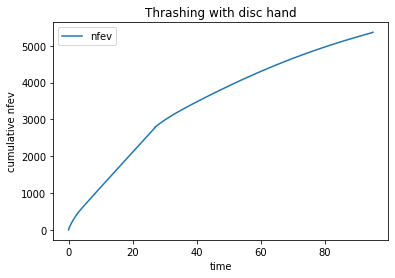

In [11]:
def high_accuracy():
    global thrashing_nfev, thrashings
    thrashing_nfev = 0
    thrashings = []

    tspan = [0, 27]
    E0 = 103
    I0 = 1
    R0 = 0
    N = 37.741 * (10**6)
    S0 = N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0)
    t_eval = np.linspace(0, 27, 28)

    start1 = timer()
    sol1 = solve_ivp(model_before, tspan, y0, t_eval=t_eval, atol=1e-12, rtol=1e-12)
    end1 = timer()

    tspan = [27, 95]
    last_index = len(sol1.y[0]) - 1
    y0 = (sol1.y[0][last_index],
            sol1.y[1][last_index],
            sol1.y[2][last_index],
            sol1.y[3][last_index])
    t_eval = np.linspace(27, 95, 95-27+1)
    start2 = timer()
    sol2 = solve_ivp(model_after, tspan, y0, t_eval=t_eval, atol=1e-12, rtol=1e-12)
    end2 = timer()
    res = (np.concatenate((sol1.t, sol2.t)), 
            np.concatenate((sol1.y, sol2.y), axis=1), 
            sol1.nfev + sol2.nfev, end1-start1 + end2-start2)


    times_thrashing = [thrashing[0] for thrashing in thrashings]
    nfev_thrashing = [thrashing[1] for thrashing in thrashings]
    plt.plot(times_thrashing, nfev_thrashing, label="nfev")
    plt.xlabel('time')
    plt.ylabel("cumulative nfev")
    plt.title(f"Thrashing with disc hand")
    plt.legend()
    plt.show()
    
    return res
(times_high, res_high, nfev_high, elapsed_high) = high_accuracy()

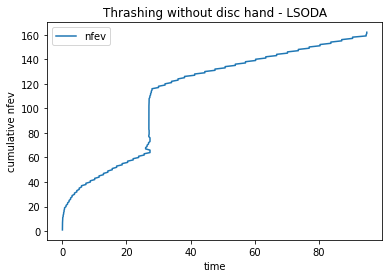

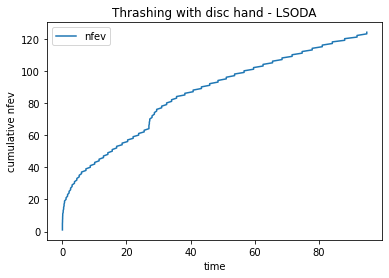

In [12]:
(times_lsoda_if, res_lsoda_if, nfev_lsoda_if, elapsed_lsoda_if) = experiment_with_if('LSODA')
(times_lsoda, res_lsoda, nfev_lsoda, elapsed_lsoda) = experiment_disc_hand("LSODA")


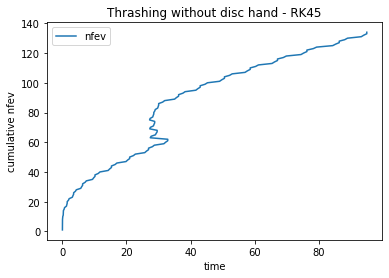

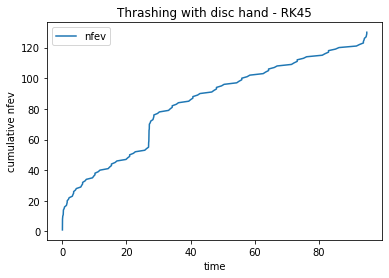

In [13]:
(times_rk45_if, res_rk45_if, nfev_rk45_if, elapsed_rk45_if) = experiment_with_if('RK45')
(times_rk45, res_rk45, nfev_rk45, elapsed_rk45) = experiment_disc_hand("RK45")

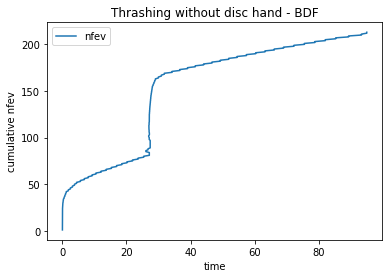

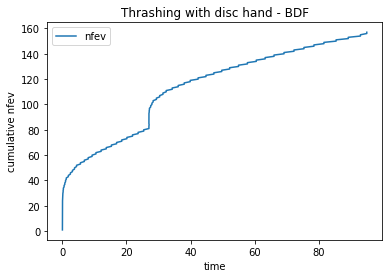

In [14]:
(times_bdf_if, res_bdf_if, nfev_bdf_if, elapsed_bdf_if) = experiment_with_if('BDF')
(times_bdf, res_bdf, nfev_bdf, elapsed_bdf) = experiment_disc_hand("BDF")


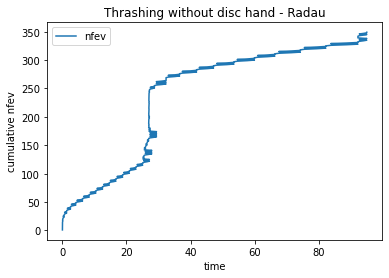

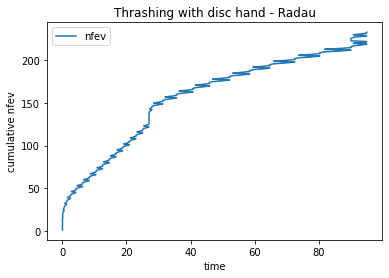

In [15]:
(times_radau_if, res_radau_if, nfev_radau_if, elapsed_radau_if) = experiment_with_if('Radau')
(times_radau, res_radau, nfev_radau, elapsed_radau) = experiment_disc_hand("Radau")

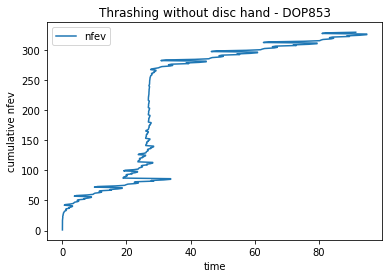

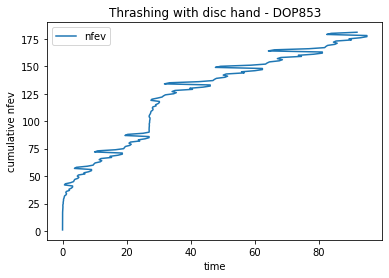

In [16]:
(times_dop853_if, res_dop853_if, nfev_dop853_if, elapsed_dop853_if) = experiment_with_if('DOP853')
(times_dop853, res_dop853, nfev_dop853, elapsed_dop853) = experiment_disc_hand("DOP853")

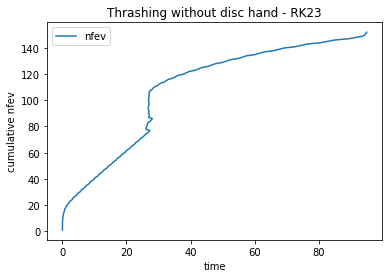

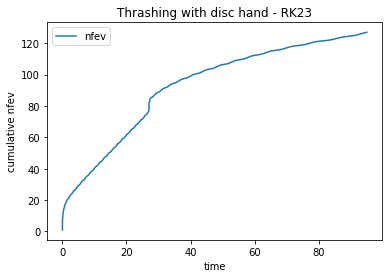

In [17]:
(times_rk23_if, res_rk23_if, nfev_rk23_if, elapsed_rk23_if) = experiment_with_if('RK23')
(times_rk23, res_rk23, nfev_rk23, elapsed_rk23) = experiment_disc_hand("RK23")

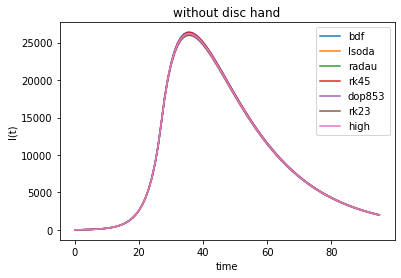

lsoda & 162 & 0.011309199999999464 \\
rk45 & 134 & 0.011992100000000505 \\
bdf & 202 & 0.05253829999999482 \\
radau & 336 & 0.039189800000002606 \\
dop853 & 329 & 0.021671199999993007 \\
rk23 & 152 & 0.01738130000000382 \\
high & 5368 & 0.17635429999999985 \\


In [18]:
plt.plot(times_bdf_if    , res_bdf_if[2], label="bdf")
plt.plot(times_lsoda_if  , res_lsoda_if[2], label="lsoda")
plt.plot(times_radau_if  , res_radau_if[2], label="radau")
plt.plot(times_rk45_if   , res_rk45_if[2], label="rk45")
plt.plot(times_dop853_if , res_dop853_if[2], label="dop853")
plt.plot(times_rk23_if   , res_rk23_if[2], label="rk23")
plt.plot(times_high      , res_high[2], label="high")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"without disc hand")
plt.legend()
plt.show()

print(f"lsoda & {nfev_lsoda_if} & {elapsed_lsoda_if} \\\\")
print(f"rk45 & {nfev_rk45_if} & {elapsed_rk45_if} \\\\")
print(f"bdf & {nfev_bdf_if} & {elapsed_bdf_if} \\\\")
print(f"radau & {nfev_radau_if} & {elapsed_radau_if} \\\\")
print(f"dop853 & {nfev_dop853_if} & {elapsed_dop853_if} \\\\")
print(f"rk23 & {nfev_rk23_if} & {elapsed_rk23_if} \\\\")
print(f"high & {nfev_high} & {elapsed_high} \\\\")


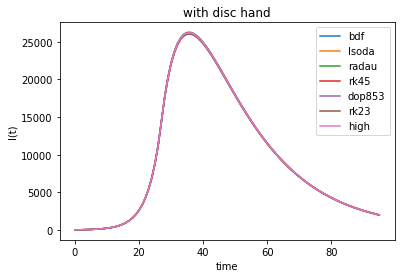

lsoda & 124 & 0.007740499999997041 \\
rk45 & 130 & 0.007582300000002817 \\
bdf & 146 & 0.030107900000004406 \\
radau & 220 & 0.01909469999999658 \\
dop853 & 181 & 0.006556899999999644 \\
rk23 & 127 & 0.009423700000006363 \\
high & 5368 & 0.17635429999999985 \\


In [19]:
plt.plot(times_bdf    , res_bdf[2], label="bdf")
plt.plot(times_lsoda  , res_lsoda[2], label="lsoda")
plt.plot(times_radau  , res_radau[2], label="radau")
plt.plot(times_rk45   , res_rk45[2], label="rk45")
plt.plot(times_dop853 , res_dop853[2], label="dop853")
plt.plot(times_rk23   , res_rk23[2], label="rk23")
plt.plot(times_high   , res_high[2], label="high")
plt.xlabel('time')
plt.ylabel("I(t)")
plt.title(f"with disc hand")
plt.legend()
plt.show()

print(f"lsoda & {nfev_lsoda} & {elapsed_lsoda} \\\\")
print(f"rk45 & {nfev_rk45} & {elapsed_rk45} \\\\")
print(f"bdf & {nfev_bdf} & {elapsed_bdf} \\\\")
print(f"radau & {nfev_radau} & {elapsed_radau} \\\\")
print(f"dop853 & {nfev_dop853} & {elapsed_dop853} \\\\")
print(f"rk23 & {nfev_rk23} & {elapsed_rk23} \\\\")
print(f"high & {nfev_high} & {elapsed_high} \\\\")